In [1]:
%load_ext autoreload
%autoreload 2

import argparse
import numpy as np
import gym

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Concatenate
from keras.optimizers import Adam

from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
import tensorflow as tf

from lifting_rl.linkage_env import LinkageEnv

Using TensorFlow backend.
/home/mans/.pyenv/versions/3.7.6/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mans/.pyenv/versions/3.7.6/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mans/.pyenv/versions/3.7.6/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/h

In [2]:
from scipy.interpolate import BSpline

In [3]:
angles_file = '/home/p.zaidel/Projects/lifting-simulation-rl/data/skeleton_angles.csv'

In [4]:
ENV_NAME = "Linkage-v0"

env = LinkageEnv(angles_file)

TypeError: __init__() missing 1 required positional argument: 'w_params'

In [6]:
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]


In [7]:
# Next, we build a very simple model.
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(16))
actor.add(Activation("relu"))
actor.add(Dense(16))
actor.add(Activation("relu"))
actor.add(Dense(16))
actor.add(Activation("relu"))
actor.add(Dense(nb_actions))
actor.add(Activation("linear"))
print(actor.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                176       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
acti

In [8]:
action_input = Input(shape=(nb_actions,), name="action_input")
observation_input = Input(
    shape=(1,) + env.observation_space.shape, name="observation_input"
)
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation("relu")(x)
x = Dense(32)(x)
x = Activation("relu")(x)
x = Dense(32)(x)
x = Activation("relu")(x)
x = Dense(1)(x)
x = Activation("linear")(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  (None, 1, 10)        0                                            
__________________________________________________________________________________________________
action_input (InputLayer)       (None, 5)            0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 10)           0           observation_input[0][0]          
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 15)           0           action_input[0][0]               
                                                                 flatten_2[0][0]                  
__________

In [9]:
memory = SequentialMemory(limit=10000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(
    size=nb_actions, theta=0.15, mu=0.0, sigma=0.3
)
agent = DDPGAgent(
    nb_actions=nb_actions,
    actor=actor,
    critic=critic,
    critic_action_input=action_input,
    memory=memory,
    nb_steps_warmup_critic=100,
    nb_steps_warmup_actor=100,
    random_process=random_process,
    gamma=0.99,
    target_model_update=1e-3,
)
agent.compile(Adam(lr=0.1, clipnorm=1.0), metrics=["mae"])

In [ ]:
agent.fit(env, nb_steps=50000, visualize=False, verbose=1, nb_max_episode_steps=200)

Training for 50000 steps ...
Interval 1 (0 steps performed)
 6143/10000 [=================>............] - ETA: 7:13 - reward: -177.9370

In [11]:
coords = env.trajectory_points
timestamps = env.trajectory_timestamps

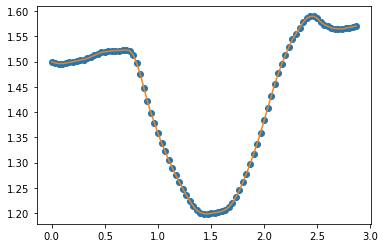

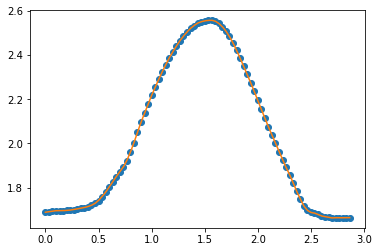

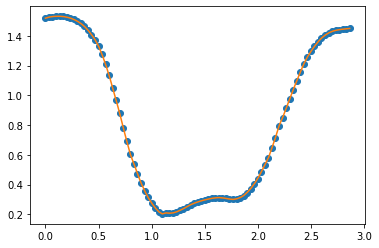

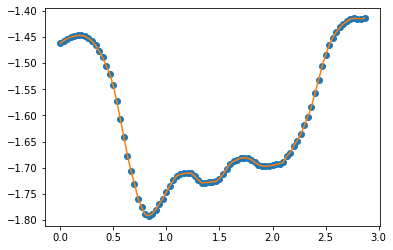

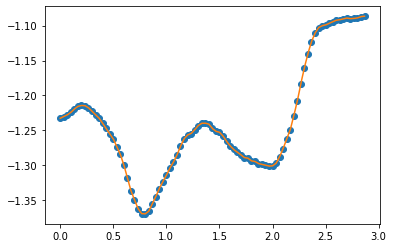

In [15]:
import matplotlib.pyplot as plt

for i in range(env.trajectory_points.shape[1]):
    xnew = np.arange(env.trajectory_timestamps.min(), env.trajectory_timestamps.max(), 0.001)
    ynew = env.interpolated_trajectory[i](xnew)
    plt.plot(env.trajectory_timestamps, env.trajectory_points[:, i], 'o')
    plt.plot(xnew, ynew, '-')
    plt.show()
    